In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Lambda,Conv2DTranspose, InputLayer
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import pandas as pd
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse, categorical_crossentropy
import matplotlib.pyplot as plt
import itertools

2023-04-07 12:40:10.012156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 12:40:10.012169: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Set up constants
BATCH_SIZE = 128
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 1
NUM_RACES = 7

In [3]:
# Load and process data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})
    data['race'] = data['race'].map({'Black': 0, 'East Asian': 1, 'Indian': 2, 'Latino_Hispanic': 3, 'Middle Eastern': 4, 'Southeast Asian': 5, 'White': 6})
    #data['race'] = pd.get_dummies(data['race'])
    data['pixels'] = data['file'].apply(lambda f: tf.keras.preprocessing.image.load_img(f, color_mode="grayscale"))
    data['pixels'] = data['pixels'].apply(lambda img: tf.keras.preprocessing.image.img_to_array(img).reshape(32, 32, 1))
    X = np.stack(data['pixels'].to_numpy(), axis=0).reshape((-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    X = (X - X.min()) / (X.max() - X.min())
    y_gender = pd.get_dummies(data['gender'])
    y_race = pd.get_dummies(data['race'])
    return X, y_gender, y_race

X_train, Y_train_gender,Y_train_race= load_data("fairface_label_train.csv")
X_test, Y_test_gender,Y_test_race= load_data("fairface_label_val.csv")

In [31]:
datagen = ImageDataGenerator()
x_train, x_val, y_train_gender, y_val_gender = train_test_split(X_train, Y_train_gender,                                                                                      
                                                                test_size=0.2, random_state=1)
x_train, x_val,  y_train_race, y_val_race = train_test_split(X_train, Y_train_race,                                                                                      
                                                             test_size=0.2, random_state=1)
# Create generators for train/validation/test sets
# train_generator = datagen.flow(X_train_gender, y_train_gender, batch_size=128)
# val_generator = datagen.flow(X_val_gender, y_val_gender, batch_size=64)
# test_generator = datagen.flow(X_test, y_test_gender) 


y_train = {'gender': y_train_gender, 'race': y_train_race}
y_val = {'gender': y_val_gender, 'race': y_val_race}

In [72]:
def fully_connected(n=2,lr=0.05):
    # Define the model
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 1)))
    model.add(Dense(1024, activation='tanh', input_dim=1024))
    model.add(Dense(512, activation='sigmoid'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n, activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.SGD(lr = lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


In [73]:
def small_cnn(n=2, lr=0.05):
    model = Sequential()
    model.add(Conv2D(filters=40, kernel_size=(5, 5), activation='relu', 
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n, activation='softmax'))
    optimizer = tf.keras.optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [74]:
def my_cnn(n=2,lr=0.05):
    model = Sequential()
    model.add(Conv2D(filters=40, kernel_size=(5, 5), activation='relu', 
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=20, kernel_size=(3, 3), activation='relu', 
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n, activation='softmax'))
    optimizer = tf.keras.optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [75]:
def my_multitask_cnn(n=2,lr=0.05):
    input_shape = (32, 32, 1)
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(40, (5, 5), padding='valid', activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    flatten1 = Flatten()(pool1)
    
    conv2 = Conv2D(40, (5, 5), padding='valid', activation='relu')(inputs)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flatten2 = Flatten()(pool2)
    
    fc1_1 = Dense(100, activation='relu')(flatten1)
    fc1_2 = Dense(100, activation='relu')(flatten2)
    
    output1 = Dense(2, activation='softmax', name='gender')(fc1_1)
    output2 = Dense(7, activation='softmax', name='race')(fc1_2)
    
    
    model = Model(inputs=inputs, outputs=[output1, output2])
    optimizer = tf.keras.optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


In [36]:
#calculate accuracy for race
def acc(y_pred,Y_test ):
    cm = confusion_matrix(y_pred.argmax(axis=1),np.array(Y_test).argmax(axis=1))
    diag_sum = 0
    for i in range(len(cm)):
        diag_sum += cm[i][i]
    acc = diag_sum/len(Y_test_race)
    print(acc)

In [37]:
# Confusion Matrix plotter
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_graphs(history, metric, title):

    fig, ax = plt.subplots()
    ax.plot(history.history[metric])
    ax.plot(history.history['val_' + metric])
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric)
    ax.legend([metric, 'val_' + metric])
    ax.set_title(title)
    plt.show()

In [76]:
# classification for gender


def run_model(model, y_train, y_val, Y_test, label, epochs=20):

    history = model.fit(x_train, y_train, 
                              steps_per_epoch=len(x_train)/ 128, 
                              validation_data=(x_val, y_val),
                              epochs=epochs, 
                              batch_size=128)
    loss, accuracy = model.evaluate(x_val, y_val, batch_size=128)

    
    print('plot traing loss: ')
#     history.history.keys()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot( loss, label='Training loss')
    plt.plot( val_loss, label='Validation loss')
    plt.title('epoch-{}_loss graph'.format(label))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_test)
    print("Accuracy for {}".format(label))
    acc(y_pred, Y_test)
      
    print('Plot confusion matrix')
    cm = confusion_matrix(Y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
    if label=='gender':
        classes=['female','male']
    else:
        classes = ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
    plt.figure()
    plot_confusion_matrix(cm, classes=classes, title='Confusion matrix for {} classification'.format(label))
#     return history

# Task 1 Fully Connected Neural Network

Epoch 1/20


/home/huanhuan/anaconda3/envs/mimic3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


542/542 [==============================] - 2s 3ms/step - loss: 0.6693 - accuracy: 0.5916 - val_loss: 0.6710 - val_accuracy: 0.5780
Epoch 2/20
542/542 [==============================] - 2s 3ms/step - loss: 0.6456 - accuracy: 0.6238 - val_loss: 0.7774 - val_accuracy: 0.5540
Epoch 3/20
542/542 [==============================] - 2s 3ms/step - loss: 0.6292 - accuracy: 0.6450 - val_loss: 0.6823 - val_accuracy: 0.5927
Epoch 4/20
542/542 [==============================] - 2s 3ms/step - loss: 0.6149 - accuracy: 0.6572 - val_loss: 0.5994 - val_accuracy: 0.6698
Epoch 5/20
542/542 [==============================] - 2s 3ms/step - loss: 0.6042 - accuracy: 0.6655 - val_loss: 0.5976 - val_accuracy: 0.6692
Epoch 6/20
542/542 [==============================] - 2s 3ms/step - loss: 0.5948 - accuracy: 0.6708 - val_loss: 0.5838 - val_accuracy: 0.6809
Epoch 7/20
542/542 [==============================] - 2s 4ms/step - loss: 0.5885 - accuracy: 0.6752 - val_loss: 0.6588 - val_accuracy: 0.5800
Epoch 8/20
542/54

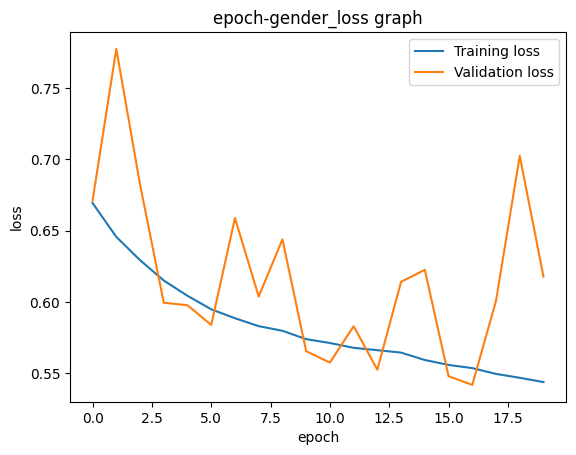

Accuracy for gender
0.6438743837867446
Plot confusion matrix
Confusion matrix, without normalization
[[1381 3781]
 [ 120 5672]]


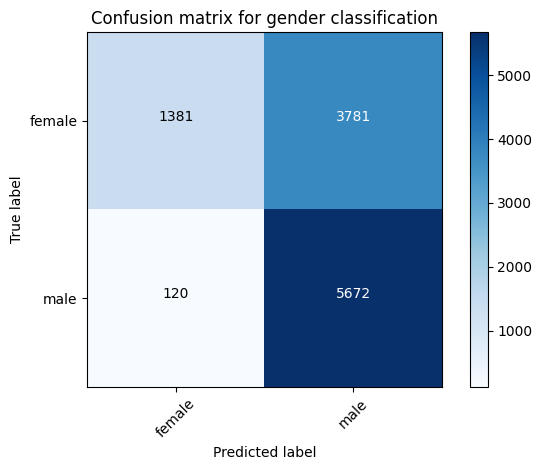

In [69]:
# classification for gender using fully connected model
model = fully_connected(n=2)
run_model(model, y_train_gender, y_val_gender, Y_test_gender, 'gender')

Epoch 1/20


/home/huanhuan/anaconda3/envs/mimic3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


542/542 [==============================] - 3s 6ms/step - loss: 1.9132 - accuracy: 0.2167 - val_loss: 1.8822 - val_accuracy: 0.2347
Epoch 2/20
542/542 [==============================] - 3s 6ms/step - loss: 1.8780 - accuracy: 0.2299 - val_loss: 1.8652 - val_accuracy: 0.2480
Epoch 3/20
542/542 [==============================] - 3s 5ms/step - loss: 1.8710 - accuracy: 0.2455 - val_loss: 1.8617 - val_accuracy: 0.2470
Epoch 4/20
542/542 [==============================] - 3s 5ms/step - loss: 1.8516 - accuracy: 0.2574 - val_loss: 1.8252 - val_accuracy: 0.2926
Epoch 5/20
542/542 [==============================] - 3s 5ms/step - loss: 1.8310 - accuracy: 0.2684 - val_loss: 1.8081 - val_accuracy: 0.2856
Epoch 6/20
542/542 [==============================] - 3s 5ms/step - loss: 1.8167 - accuracy: 0.2817 - val_loss: 1.7932 - val_accuracy: 0.2970
Epoch 7/20
542/542 [==============================] - 3s 5ms/step - loss: 1.8062 - accuracy: 0.2843 - val_loss: 1.8083 - val_accuracy: 0.2790
Epoch 8/20
542/54

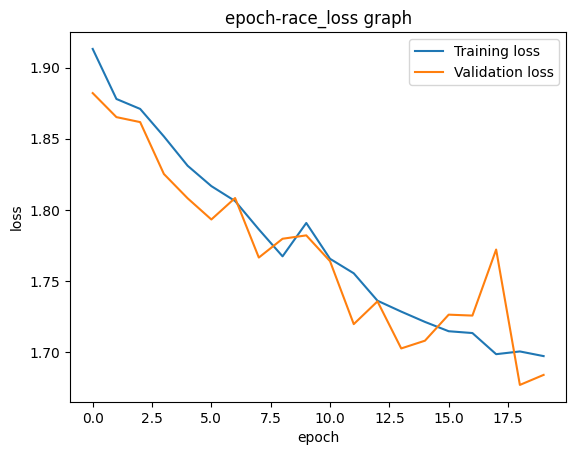

Accuracy for race
0.3427971517253971
Plot confusion matrix
Confusion matrix, without normalization
[[1075  113   97   35   10   42  184]
 [ 169 1008   49   38    6   52  228]
 [ 451  198  362  137   35   66  267]
 [ 286  376  163  184   35   70  509]
 [ 236  198  112  105   71   22  465]
 [ 305  599  106   68    6   99  232]
 [ 368  449  104  137   32   39  956]]


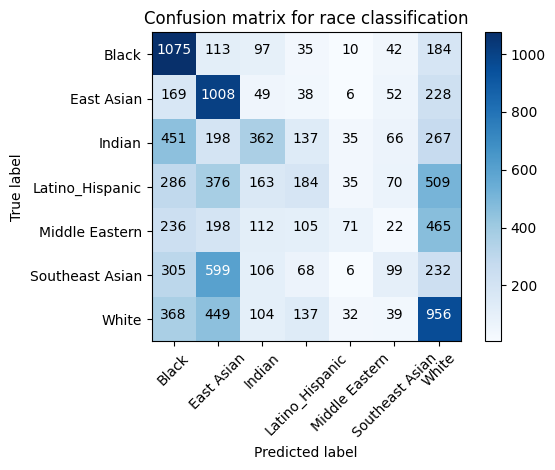

In [57]:
# classification for race using fully connected model
model = fully_connected(n=7)
run_model(model, y_train_race, y_val_race, Y_test_race, 'race')

# Task 2: Small Convolutional Neural Network

Epoch 1/20


/home/huanhuan/anaconda3/envs/mimic3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


542/542 [==============================] - 6s 10ms/step - loss: 0.6413 - accuracy: 0.6308 - val_loss: 0.6201 - val_accuracy: 0.6560
Epoch 2/20
542/542 [==============================] - 7s 13ms/step - loss: 0.5748 - accuracy: 0.6965 - val_loss: 0.5589 - val_accuracy: 0.7086
Epoch 3/20
542/542 [==============================] - 13s 24ms/step - loss: 0.5418 - accuracy: 0.7192 - val_loss: 0.5330 - val_accuracy: 0.7219
Epoch 4/20
542/542 [==============================] - 12s 23ms/step - loss: 0.5163 - accuracy: 0.7355 - val_loss: 0.5280 - val_accuracy: 0.7200
Epoch 5/20
542/542 [==============================] - 13s 23ms/step - loss: 0.4912 - accuracy: 0.7522 - val_loss: 0.4855 - val_accuracy: 0.7535
Epoch 6/20
542/542 [==============================] - 13s 24ms/step - loss: 0.4722 - accuracy: 0.7647 - val_loss: 0.6208 - val_accuracy: 0.6542
Epoch 7/20
542/542 [==============================] - 13s 24ms/step - loss: 0.4546 - accuracy: 0.7778 - val_loss: 0.4636 - val_accuracy: 0.7708
Epoch

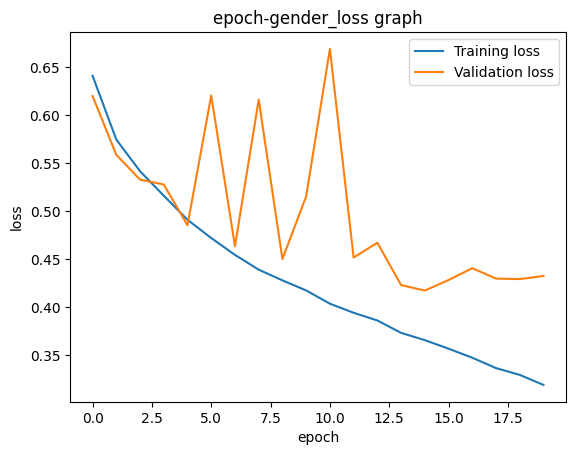

Accuracy for gender
0.790304911447873
Plot confusion matrix
Confusion matrix, without normalization
[[3889 1273]
 [1024 4768]]


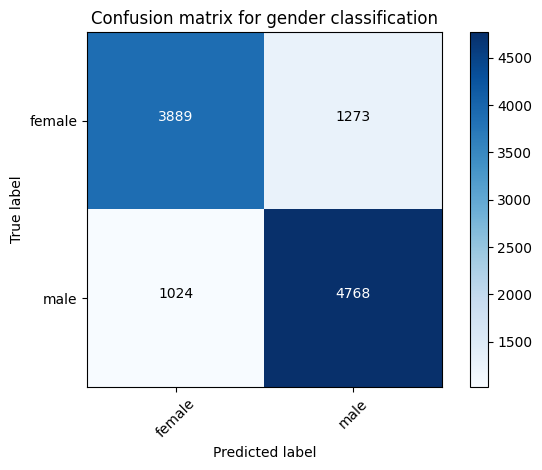

In [81]:
# classification for gender using small cnn model
model = small_cnn(n=2)
run_model(model, y_train_gender, y_val_gender, Y_test_gender, 'gender',epochs=20)

Epoch 1/20


/home/huanhuan/anaconda3/envs/mimic3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


542/542 [==============================] - 13s 23ms/step - loss: 1.8309 - accuracy: 0.2710 - val_loss: 1.8014 - val_accuracy: 0.2820
Epoch 2/20
542/542 [==============================] - 13s 23ms/step - loss: 1.7024 - accuracy: 0.3419 - val_loss: 1.8397 - val_accuracy: 0.2680
Epoch 3/20
542/542 [==============================] - 13s 23ms/step - loss: 1.6273 - accuracy: 0.3767 - val_loss: 1.7108 - val_accuracy: 0.3269
Epoch 4/20
542/542 [==============================] - 12s 23ms/step - loss: 1.5756 - accuracy: 0.3982 - val_loss: 1.6206 - val_accuracy: 0.3695
Epoch 5/20
542/542 [==============================] - 13s 24ms/step - loss: 1.5323 - accuracy: 0.4173 - val_loss: 1.5926 - val_accuracy: 0.3794
Epoch 6/20
542/542 [==============================] - 13s 24ms/step - loss: 1.4923 - accuracy: 0.4323 - val_loss: 1.5618 - val_accuracy: 0.3898
Epoch 7/20
542/542 [==============================] - 13s 23ms/step - loss: 1.4561 - accuracy: 0.4465 - val_loss: 1.7985 - val_accuracy: 0.3171
Epo

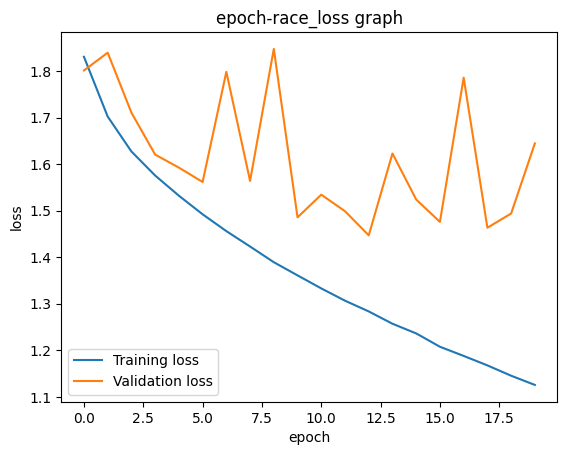

Accuracy for race
0.3993061895198101
Plot confusion matrix
Confusion matrix, without normalization
[[913  10  79 370  78  19  87]
 [ 34 461  11 602 104 111 227]
 [ 91  12 431 559 288  12 123]
 [ 42  27  68 910 319  16 241]
 [ 24  12  35 366 574   3 195]
 [ 69 145  54 727 107 182 131]
 [ 39  37  24 616 452  14 903]]


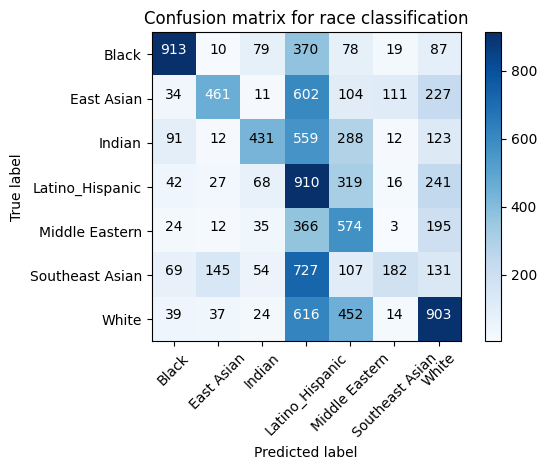

In [71]:
# classification for race using small cnn model
model = small_cnn(n=7)
run_model(model, y_train_race, y_val_race, Y_test_race, 'race',epochs=20)

# Task 3: Our own Convolutional Neural Network

Epoch 1/20


/home/huanhuan/anaconda3/envs/mimic3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


542/542 [==============================] - 15s 28ms/step - loss: 0.6582 - accuracy: 0.6089 - val_loss: 0.6353 - val_accuracy: 0.6376
Epoch 2/20
542/542 [==============================] - 17s 31ms/step - loss: 0.5952 - accuracy: 0.6783 - val_loss: 0.5720 - val_accuracy: 0.7023
Epoch 3/20
542/542 [==============================] - 17s 31ms/step - loss: 0.5540 - accuracy: 0.7122 - val_loss: 0.5417 - val_accuracy: 0.7189
Epoch 4/20
542/542 [==============================] - 17s 31ms/step - loss: 0.5308 - accuracy: 0.7270 - val_loss: 0.5594 - val_accuracy: 0.7055
Epoch 5/20
542/542 [==============================] - 17s 31ms/step - loss: 0.5112 - accuracy: 0.7402 - val_loss: 0.7499 - val_accuracy: 0.5689
Epoch 6/20
542/542 [==============================] - 17s 31ms/step - loss: 0.4959 - accuracy: 0.7504 - val_loss: 0.5319 - val_accuracy: 0.7221
Epoch 7/20
542/542 [==============================] - 17s 31ms/step - loss: 0.4819 - accuracy: 0.7604 - val_loss: 0.7070 - val_accuracy: 0.6495
Epo

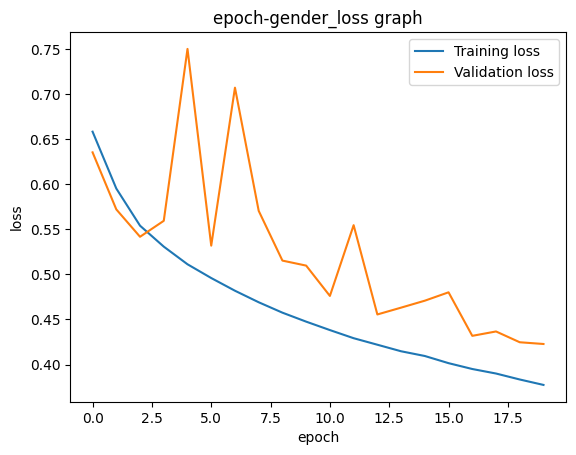

Accuracy for gender
0.7960562351652365
Plot confusion matrix
Confusion matrix, without normalization
[[3920 1242]
 [ 992 4800]]


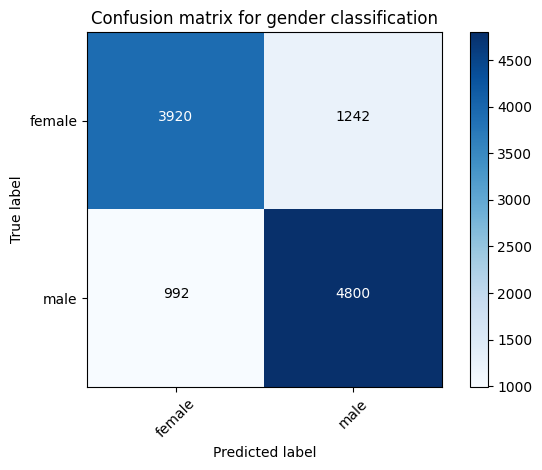

In [82]:
# classification for gender using small cnn model
model = my_cnn(n=2)
run_model(model, y_train_gender, y_val_gender, Y_test_gender, 'gender')

/home/huanhuan/anaconda3/envs/mimic3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
542/542 [==============================] - 17s 31ms/step - loss: 1.8788 - accuracy: 0.2355 - val_loss: 1.8629 - val_accuracy: 0.2593
Epoch 2/20
542/542 [==============================] - 18s 33ms/step - loss: 1.7905 - accuracy: 0.2994 - val_loss: 1.7813 - val_accuracy: 0.2869
Epoch 3/20
542/542 [==============================] - 18s 33ms/step - loss: 1.7094 - accuracy: 0.3377 - val_loss: 1.7079 - val_accuracy: 0.3356
Epoch 4/20
542/542 [==============================] - 17s 31ms/step - loss: 1.6457 - accuracy: 0.3667 - val_loss: 1.6346 - val_accuracy: 0.3757
Epoch 5/20
542/542 [==============================] - 17s 31ms/step - loss: 1.5973 - accuracy: 0.3859 - val_loss: 1.7275 - val_accuracy: 0.3270
Epoch 6/20
542/542 [==============================] - 16s 30ms/step - loss: 1.5540 - accuracy: 0.4049 - val_loss: 1.5696 - val_accuracy: 0.3995
Epoch 7/20
542/542 [==============================] - 17s 31ms/step - loss: 1.5208 - accuracy: 0.4158 - val_loss: 1.5518 - val_accuracy:

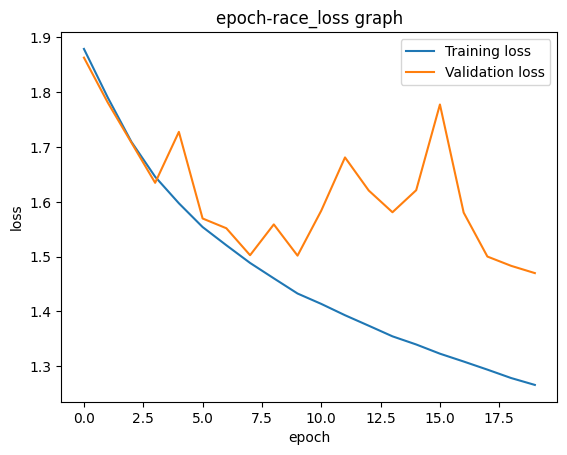

Accuracy for race
0.4454993609640314
Plot confusion matrix
Confusion matrix, without normalization
[[1038   33  133  205   48   48   51]
 [  55  876   63  234   50  177   95]
 [ 152   51  602  395  204   42   70]
 [  97   92  176  818  236   44  160]
 [  32   41  121  370  492   23  130]
 [ 118  345  109  394   53  326   70]
 [  79  132  116  629  355   46  728]]


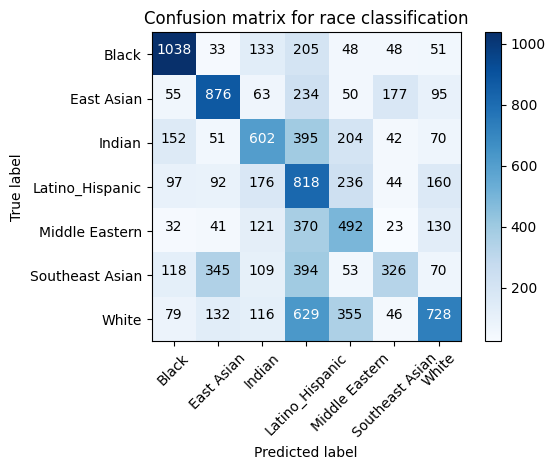

In [83]:
# classification for race using small cnn model
model = my_cnn(n=7)
run_model(model, y_train_race, y_val_race, Y_test_race, 'race')

# Task 4: Our own Convolutional Neural Network on both Tasks Simultaneously

In [98]:
def run_multitask_model(model, y_train, y_val, Y_test_gender,Y_test_race, epochs=20):

    history = model.fit(x_train, y_train, 
                              steps_per_epoch=len(x_train)/ 128, 
                              validation_data=(x_val, y_val),
                              epochs=epochs, 
                              batch_size=128)
    loss, accuracy, *other= model.evaluate(x_val, y_val, batch_size=128)

    
    print('plot traing loss: ')
#     history.history.keys()
    gender_loss = history.history['gender_loss']
    val_gender_loss = history.history['val_gender_loss']
    plt.plot( gender_loss, label='Training loss')
    plt.plot( val_gender_loss, label='Validation loss')
    plt.title('epoch-gender_loss graph')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    
    race_loss = history.history['race_loss']
    val_race_loss = history.history['val_race_loss']
    plt.plot( race_loss, label='Training loss')
    plt.plot( val_race_loss, label='Validation loss')
    plt.title('epoch-race_loss graph')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
              
              
    y_pred = model.predict(X_test)
    print("Accuracy for gender")
    acc(y_pred[0], Y_test_gender)
    print("Accuracy for race")
    acc(y_pred[1], Y_test_race)
      
    print('Plot confusion matrix')
    cm_gender = confusion_matrix(Y_test_gender.values.argmax(axis=1), y_pred[0].argmax(axis=1))
    classes=['female','male']
    plt.figure()
    plot_confusion_matrix(cm_gender, classes=classes, title='Confusion matrix for gender classification')
    cm_race = confusion_matrix(Y_test_race.values.argmax(axis=1), y_pred[1].argmax(axis=1))
    classes = ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
    plt.figure()
    plot_confusion_matrix(cm_race, classes=classes, title='Confusion matrix for race classification')
#     return history

Epoch 1/20


/home/huanhuan/anaconda3/envs/mimic3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


542/542 [==============================] - 12s 22ms/step - loss: 2.4763 - gender_loss: 0.6396 - race_loss: 1.8367 - gender_accuracy: 0.6314 - race_accuracy: 0.2696 - val_loss: 2.4331 - val_gender_loss: 0.6068 - val_race_loss: 1.8263 - val_gender_accuracy: 0.6716 - val_race_accuracy: 0.2673
Epoch 2/20
542/542 [==============================] - 23s 43ms/step - loss: 2.2688 - gender_loss: 0.5716 - race_loss: 1.6972 - gender_accuracy: 0.7000 - race_accuracy: 0.3431 - val_loss: 2.3421 - val_gender_loss: 0.5608 - val_race_loss: 1.7812 - val_gender_accuracy: 0.7058 - val_race_accuracy: 0.3222
Epoch 3/20
542/542 [==============================] - 21s 40ms/step - loss: 2.1619 - gender_loss: 0.5402 - race_loss: 1.6217 - gender_accuracy: 0.7219 - race_accuracy: 0.3805 - val_loss: 2.3215 - val_gender_loss: 0.6818 - val_race_loss: 1.6396 - val_gender_accuracy: 0.6127 - val_race_accuracy: 0.3618
Epoch 4/20
542/542 [==============================] - 21s 39ms/step - loss: 2.0821 - gender_loss: 0.5140 

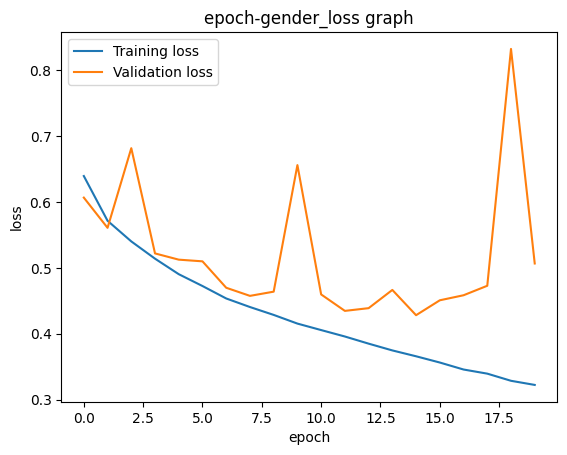

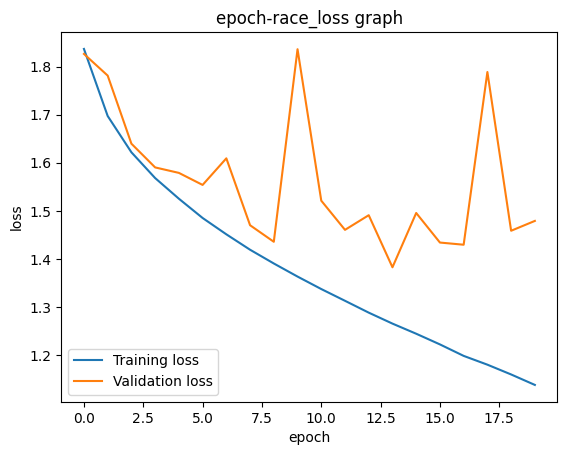

Accuracy for gender
0.767482198283732
Accuracy for race
0.45846266204126346
Plot confusion matrix
Confusion matrix, without normalization
[[3025 2137]
 [ 410 5382]]


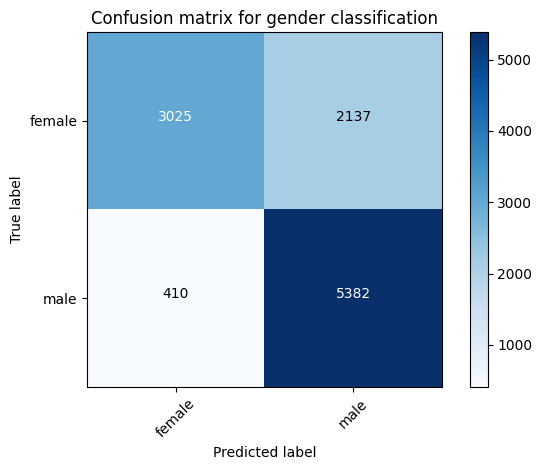

Confusion matrix, without normalization
[[ 954   34  288   68    2  141   69]
 [  35  775   90   52    4  493  101]
 [ 112   36 1020   87   19  139  103]
 [  79   90  531  425   25  236  237]
 [  34   53  409  257  126   84  246]
 [  61  234  207   74    3  765   71]
 [  78  148  334  294   55  219  957]]


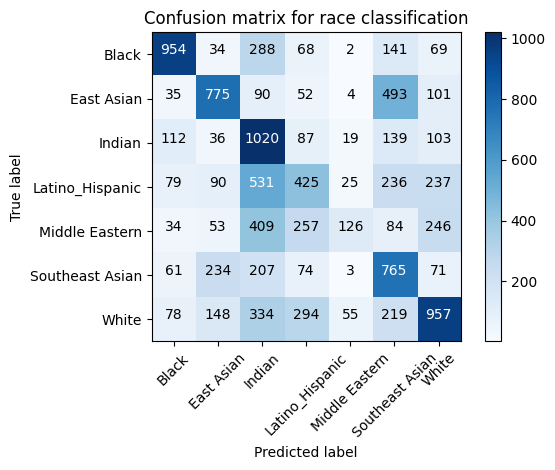

In [99]:
model = my_multitask_cnn()
run_multitask_model(model, y_train, y_val, Y_test_gender, Y_test_race, epochs=20)

In [97]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    #Extract mean and log of variance
    z_mean, z_log_var = args
    #get batch size and length of vector (size of latent space)
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    #Return sampled number (need to raise var to correct power)
    return z_mean + K.exp(z_log_var) * epsilon

# Task 5: Variational Auto Encoder 

In [98]:
# network parameters
input_shape = (32, 32, 1)
original_dim = 32 * 32
intermediate_dim = 16
batch_size = 32
latent_dim = 10
kernel_size = 3
filters = 16

In [99]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters, kernel_size, padding='same',strides=2, activation='relu')(x)
    
shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(intermediate_dim, activation='relu', name="encoder_hidden_layer")(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder_output')
encoder.summary()

Model: "encoder_output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_21 (Conv2D)             (None, 8, 8, 64)     18496       ['conv2d_20[0][0]']              
                                                                                                  
 flatten_10 (Flatten)           (None, 4096)         0           ['conv2d_21[0][0]']              
                                                                                     

In [100]:
# build decoder model

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = tf.keras.layers.Reshape(target_shape=(shape[1], shape[2], shape[3]))(x)
for i in range(2):
    x = Conv2DTranspose(filters, kernel_size, activation='relu', strides=2, padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same',name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder_output')
decoder.summary()

Model: "decoder_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 10)]              0         
                                                                 
 dense_11 (Dense)            (None, 4096)              45056     
                                                                 
 reshape_11 (Reshape)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_23 (Conv2D  (None, 16, 16, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 32, 32, 32)       18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTrans  (None, 32, 32, 1)     

In [102]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

image_size = 32
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [103]:
vae.fit(X_train.squeeze(), epochs=5, batch_size=batch_size,validation_data=(X_test.squeeze(), None))

Epoch 1/5
2711/2711 [==============================] - 53s 19ms/step - loss: 37.3493 - val_loss: 35.3144
Epoch 2/5
2711/2711 [==============================] - 55s 20ms/step - loss: 34.8694 - val_loss: 35.0984
Epoch 3/5
2711/2711 [==============================] - 55s 20ms/step - loss: 33.7342 - val_loss: 29.6431
Epoch 4/5
2711/2711 [==============================] - 55s 20ms/step - loss: 28.7997 - val_loss: 28.5729
Epoch 5/5
2711/2711 [==============================] - 55s 20ms/step - loss: 28.1777 - val_loss: 28.1679


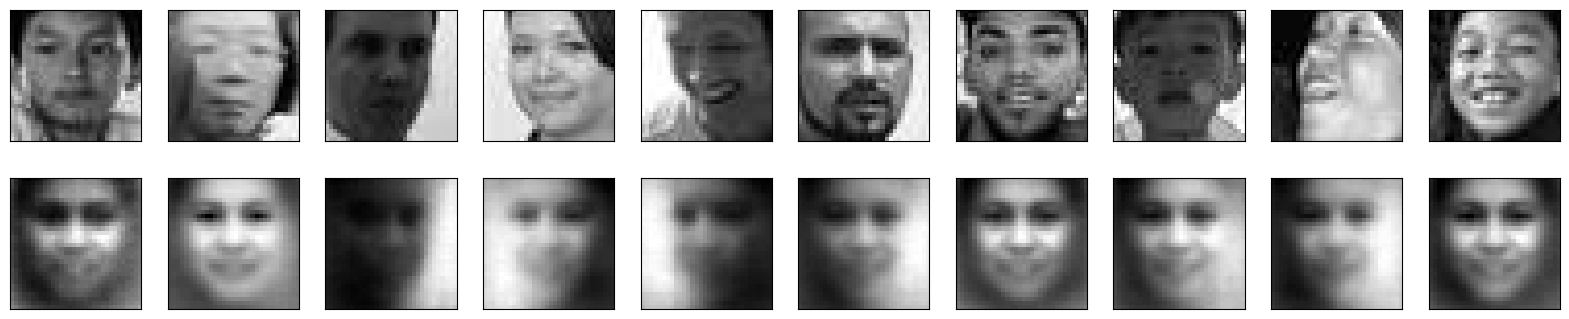

In [123]:
decoded_imgs = vae.predict(X_test.squeeze())
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()